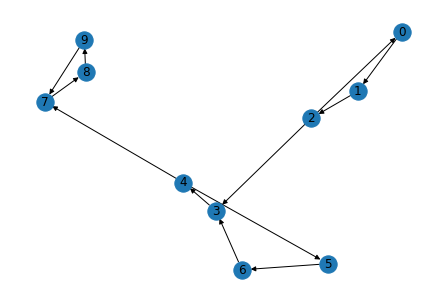

In [42]:
import numpy as np
import networkx as nx

J = nx.DiGraph()

J.add_edge(0,1)
J.add_edge(1,2)
J.add_edge(2,0)
J.add_edge(2,3)
J.add_edge(3,4)
J.add_edge(4,5)
J.add_edge(6,3)
J.add_edge(5,6)
J.add_edge(4,7)
J.add_edge(7,8)
J.add_edge(8,9)
J.add_edge(9,7)

flows = {}

flows[(0,1)] = 10.
flows[(1,2)] = 10
flows[(2,0)] = 10.
flows[(2,3)] = 0.
flows[(3,4)] = 20.
flows[(4,5)] = 20.
flows[(6,3)] = 20
#flows[(6,4)] = 10.
flows[(5,6)] = 20.
flows[(4,7)] = 0
flows[(7,8)] = 30
flows[(8,9)] = 30
flows[(9,7)] = 30

np.random.seed(540)
nx.draw(J, with_labels=True)

In [2]:
from sensors import *

opt = choose_sensors(J, flows, flow_prediction, mse, 3)
opt

  0%|          | 0/3 [00:00<?, ?it/s]

[(9, 7), (3, 4), (0, 1)]

In [3]:
mse(flows, flow_prediction(J, {s : flows[s] for s in opt}))

2.082821407672434e-21

In [4]:
opt_lazy = choose_sensors(J, flows, flow_prediction, mse, lazy=True, k=3)
opt_lazy

  0%|          | 0/3 [00:00<?, ?it/s]

[(9, 7), (3, 4), (0, 1)]

In [5]:
mse(flows, flow_prediction(J, {s : flows[s] for s in opt_lazy}))

2.082821407672434e-21

In [6]:
flow_prediction(J, {s : flows[s] for s in opt_lazy})

{(0, 1): 10.0,
 (1, 2): 10.000000000011017,
 (2, 0): 9.999999999968992,
 (2, 3): 6.298117583014573e-11,
 (3, 4): 20.0,
 (4, 5): 19.99999999993401,
 (4, 7): 2.6997959423624707e-11,
 (5, 6): 19.99999999991502,
 (6, 3): 19.99999999991601,
 (7, 8): 29.999999999988013,
 (8, 9): 29.999999999979003,
 (9, 7): 30}

In [7]:
mape(flows, flow_prediction(J, {s : flows[s] for s in opt_lazy}))

1.70500650635657e-09

In [43]:
def synthetic_speeds(G):
    eigs = np.linalg.eig(nx.laplacian_matrix(nx.line_graph(G).to_undirected(), nodelist=nx.line_graph(G).nodes()).toarray())
    order = np.argsort(eigs[0])
    
    vals = eigs[1][:,-1]
    speeds = {}
    for i, v in enumerate(nx.line_graph(G).nodes()):
        speeds[v] = vals[i]
    return speeds

In [ ]:
def choose_sensors(G, labeled_edges, predict, evaluate, k=None, lazy=True, cores=8, debug=False):
    """
    Choose `k` sensors greedily to optimize the prediction given by `predict` for ground truth `labels`
    based on loss function `evaluate` (lower loss is better). 
    
    Parameters:
        -- G: networkx graph
        -- labeled_edges: dict {edge : value}
        -- predict: function taking G, labeled_edges -> prediction
        -- evaluate: prediction, true_values -> loss
    """
    if k == None:
        k = int(G.number_of_edges())
    
    sensors = []
    
    candidates = list(labeled_edges.keys())
    np.random.shuffle(candidates)
    sensors += candidates[:int(len(candidates / 100))]
        
    # Find value of adding each edge not in the set
    current = evaluate(predict(G, {}), labeled_edges)

    with Pool(cores) as pool:
        deltas = pool.map(lambda e: (evaluate(predict(G, {e : labeled_edges[e]}), labeled_edges) - current, e), 
                          labeled_edges)

    heapq.heapify(deltas)
    
    if debug:
        print("initial len(deltas):", len(deltas))
    
    # Greedily select sensors
    if lazy:
        for i in tqdm(range(k)):
            current = evaluate(predict(G, {e: labeled_edges[e] for e in sensors}), labeled_edges)
            if debug:
                print("iteration {}, current {}".format(i, current))

            # Current top 
            _, s = heapq.heappop(deltas)
            delta = evaluate(predict(G, {e: labeled_edges[e] for e in sensors} | {s : labeled_edges[s]}), 
                             labeled_edges) - current
            
            if len(deltas) == 0:
                sensors.append(s)
                continue

            # Next top
            delta_next, s_next = heapq.heappop(deltas)
            #delta_next -= current
            
            if debug:
                print("sensor {} delta {}".format(s, delta))
                print("next top sensor {} delta {}".format(s_next, delta_next))
            
#             if delta <= delta_next:
                
                
            # If the change drops it below the next best, recalculate the next best and continue
            while delta > delta_next:
                delta_next = evaluate(predict(G, {e: labeled_edges[e] for e in sensors} | {s_next : labeled_edges[s_next]}), 
                             labeled_edges) - current
                if debug:
                    print("sensor {} delta {}".format(s, delta))
                    print("next top sensor {} delta {}".format(s_next, delta_next))
                    
                if delta_next <= delta:
                    heapq.heappush(deltas, (delta, s))
                    delta, s = delta_next, s_next
                    if debug:
                        print("next < delta, len(deltas)", len(deltas))
                else:
                    heapq.heappush(deltas, (delta_next, s_next))
                    if debug:
                        print("nest > delta, len(deltas):", len(deltas))
                
                delta_next, s_next = heapq.heappop(deltas)
                    
#                     if delta <= delta_next:
#                         heapq.heappush(deltas, (delta_next, s_next))
#                         break
            
            heapq.heappush(deltas, (delta_next, s_next))
        
            if len(deltas) != len(labeled_edges) - i - 1:
                print("error: iteration", i, "len(deltas):", len(deltas))
                return sensors
            
            if debug:    
                print("iteration", i, "len(deltas):", len(deltas))
                print("selecting sensor {} delta {}, next sensor {} has delta {}".format(s, delta, s_next, delta_next))
                print()

            sensors.append(s)
    else:
        for i in tqdm(range(k)):
            current = evaluate(predict(G, {e: labeled_edges[e] for e in sensors}), labeled_edges)
            if debug:
                print("iteration {}, current {}".format(i, current))
            opt, opt_cost = None, float("inf")
            for s in G.edges():
                if s not in sensors:
                    cost = evaluate(predict(G, {e : labeled_edges[e] for e in sensors} | {s : labeled_edges[s]}),
                                   labeled_edges)
                    if debug:
                        print("sensor {} cost {} opt {}".format(s, cost, opt_cost))
                    if cost < opt_cost:
                        opt, opt_cost = s, cost
            sensors.append(opt)
        
    return sensors

In [50]:
G = nx.path_graph(10)
speeds = synthetic_speeds(G)
speeds

{(0, 1): 0.44297534959244966,
 (8, 9): 0.44297534959244966,
 (6, 7): -0.08185853597931515,
 (7, 8): 0.23570226039551587,
 (1, 2): 0.23570226039551562,
 (2, 3): -0.0818585359793154,
 (5, 6): -0.3611168136131347,
 (3, 4): -0.3611168136131347,
 (4, 5): -0.47140452079103184}

In [51]:
opt = choose_sensors(G, speeds, speed_prediction, mse, lazy=True, debug=True)

initial len(deltas): 9


  0%|          | 0/9 [00:00<?, ?it/s]

iteration 0, current 0.1111111111111111
sensor (2, 3) delta 0.006700819905388775
next top sensor (6, 7) delta 0.006700819905404373
iteration 0 len(deltas): 8
selecting sensor (2, 3) delta 0.006700819905388775, next sensor (6, 7) has delta 0.006700819905404373

iteration 1, current 0.11781193101649988
sensor (6, 7) delta 7.094450027445021e-12
next top sensor (7, 8) delta 0.055555555409324275
iteration 1 len(deltas): 7
selecting sensor (6, 7) delta 7.094450027445021e-12, next sensor (7, 8) has delta 0.055555555409324275

iteration 2, current 0.11781193102359433
sensor (7, 8) delta -0.03703703703682899
next top sensor (1, 2) delta 0.05555555540933549
iteration 2 len(deltas): 6
selecting sensor (7, 8) delta -0.03703703703682899, next sensor (1, 2) has delta 0.05555555540933549

iteration 3, current 0.08077489398676534
sensor (1, 2) delta -0.03703703703682884
next top sensor (3, 4) delta 0.1304053529976901
iteration 3 len(deltas): 5
selecting sensor (1, 2) delta -0.03703703703682884, next s

In [ ]:
G = nx.gnp_random_graph(10, 0.3)
speeds = synthetic_speeds(G)
nx.draw(G, with_labels=True, edge_color=[speeds[e] for e in G.edges()], node_color="white")
# G = nx.path_graph(5)

In [16]:
def speed_prediction_iterative(G, labeled_flows, iters=1000, P=None):
    x = dict2vect(G, labeled_flows)
    G_line = nx.line_graph(G)
    
    fixed = []
    for i, e in enumerate(G_line.nodes()):
        if e in labeled_flows:
            fixed.append((i,e))
    
    if P == None:
        A = nx.adjacency_matrix(G_line)

        D = np.zeros((G_line.number_of_nodes(), G_line.number_of_nodes()))
        for i, e in enumerate(G_line.nodes()):
            D[i][i] = G_line.degree[e]
    
        P = np.linalg.inv(D) @ A
    
    for i in range(iters):
        x = P @ x
        for j, e in fixed:
            x[j] = labeled_flows[e]
    
    return vect2dict(G, x)

In [33]:
opt = choose_sensors(G, speeds, speed_prediction, mse)
opt

  0%|          | 0/16 [00:00<?, ?it/s]

[(4, 5),
 (1, 2),
 (0, 8),
 (2, 3),
 (2, 9),
 (8, 9),
 (5, 9),
 (4, 6),
 (6, 9),
 (3, 4),
 (0, 6),
 (0, 1),
 (6, 7),
 (3, 5),
 (5, 7),
 (1, 7)]

In [34]:
for i in range(1, G.number_of_edges()+1):
    print(opt[:i], mse(speeds, speed_prediction(G, {s : speeds[s] for s in opt[:i]})))

[(4, 5)] 0.06251778790253237
[(4, 5), (1, 2)] 0.06257871699227802
[(4, 5), (1, 2), (0, 8)] 0.06265314843748793
[(4, 5), (1, 2), (0, 8), (2, 3)] 0.0626736541337979
[(4, 5), (1, 2), (0, 8), (2, 3), (2, 9)] 0.06277682748114907
[(4, 5), (1, 2), (0, 8), (2, 3), (2, 9), (8, 9)] 0.06313825741025757
[(4, 5), (1, 2), (0, 8), (2, 3), (2, 9), (8, 9), (5, 9)] 0.06111067748310041
[(4, 5), (1, 2), (0, 8), (2, 3), (2, 9), (8, 9), (5, 9), (4, 6)] 0.061718831615872355
[(4, 5), (1, 2), (0, 8), (2, 3), (2, 9), (8, 9), (5, 9), (4, 6), (6, 9)] 0.06242758083451798
[(4, 5), (1, 2), (0, 8), (2, 3), (2, 9), (8, 9), (5, 9), (4, 6), (6, 9), (3, 4)] 0.060964798966440775
[(4, 5), (1, 2), (0, 8), (2, 3), (2, 9), (8, 9), (5, 9), (4, 6), (6, 9), (3, 4), (0, 6)] 0.06288842590263585
[(4, 5), (1, 2), (0, 8), (2, 3), (2, 9), (8, 9), (5, 9), (4, 6), (6, 9), (3, 4), (0, 6), (0, 1)] 0.05734714249219644
[(4, 5), (1, 2), (0, 8), (2, 3), (2, 9), (8, 9), (5, 9), (4, 6), (6, 9), (3, 4), (0, 6), (0, 1), (6, 7)] 0.0500663302181068

In [36]:
opt.reverse()
for i in range(1, G.number_of_edges()+1):
    print(opt[:i], mse(speeds, speed_prediction(G, {s : speeds[s] for s in opt[:i]})))

[(1, 7)] 0.283238701725623
[(1, 7), (5, 7)] 0.06641255257404138
[(1, 7), (5, 7), (3, 5)] 0.07328200134674011
[(1, 7), (5, 7), (3, 5), (6, 7)] 0.04399632455751086
[(1, 7), (5, 7), (3, 5), (6, 7), (0, 1)] 0.037985988617578785
[(1, 7), (5, 7), (3, 5), (6, 7), (0, 1), (0, 6)] 0.01889738884426277
[(1, 7), (5, 7), (3, 5), (6, 7), (0, 1), (0, 6), (3, 4)] 0.010125210632288837
[(1, 7), (5, 7), (3, 5), (6, 7), (0, 1), (0, 6), (3, 4), (6, 9)] 0.008625977450217403
[(1, 7), (5, 7), (3, 5), (6, 7), (0, 1), (0, 6), (3, 4), (6, 9), (4, 6)] 0.006763418710145063
[(1, 7), (5, 7), (3, 5), (6, 7), (0, 1), (0, 6), (3, 4), (6, 9), (4, 6), (5, 9)] 0.007753475772777129
[(1, 7), (5, 7), (3, 5), (6, 7), (0, 1), (0, 6), (3, 4), (6, 9), (4, 6), (5, 9), (8, 9)] 0.00410194356538008
[(1, 7), (5, 7), (3, 5), (6, 7), (0, 1), (0, 6), (3, 4), (6, 9), (4, 6), (5, 9), (8, 9), (2, 9)] 0.0019326052009369585
[(1, 7), (5, 7), (3, 5), (6, 7), (0, 1), (0, 6), (3, 4), (6, 9), (4, 6), (5, 9), (8, 9), (2, 9), (2, 3)] 0.001019229819